# Situation Report: 29th October 2024
I have a meeting with my supervisor tomorrow, the first one since starting work on this project. As a result, a lot of things have happened; it is sensible, I think, to go through everything I've done so far and explain my reasoning for each step, to ensure it is well-organised in my mind before I speak to her about it. I will also go through what problems I currently face, and a rough roadmap for where I see this project going. Note: I have decided to write this in a Jupyter notebook, as it allows me to more explicitly talk through what code I have done.

In [1]:
from qiskit import QuantumCircuit
from lambeq import BobcatParser, RemoveCupsRewriter, AtomicType, IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit


## Progress Up To This Point
My progress up to this point can be broken up into a series of bullet points, all of which will be explained fully in their own sections. So far I have:

- Created a very simple swap test circuit for fidelity evaluation and tested it briefly.
- Trained a Lambeq model using the `mc_train` and `mc_dev` data found in the [lambeq docs](https://github.com/CQCL/lambeq-docs/tree/main/docs/examples/datasets) and evaluated its accuracy using the `mc_test` data found in the same location.
- Written a function to parse a sentence through the trained model and extract the resulting quantum circuit.
- Written a function which composes the quantum circuits of two sentences and adds a swap test circuit to test the fidelity between the sentence qubits.
- Written a function to rank the similarity of sentences using both my lambeq model and a pre-tested BERT model.
- Implemented a vague arbitrary NDCG calculation to quantifiably evaluate the rankings of my model against the rankings of the BERT model.

### Simple Swap Test

Consider two states, $|\psi\rangle$ and $\phi\rangle$. Conceptually the simplest measurement fidelity is the absolute square of the contraction of these two states:

$\begin{equation}
\textrm{Fidelity} = |\langle \phi|\psi\rangle|^2
\end{equation}$

As outlined by [Basheer, Afham and Goyal](https://arxiv.org/pdf/2003.09187) in 2021, a simple swap test can be used to determine the fidelity between two qubit states. The swap test is shown below - qubits 1 and 2 have the states you wish to compare, and qubit 0 acts as a 'control' qubit which is measured to obtain the fidelity measurement.

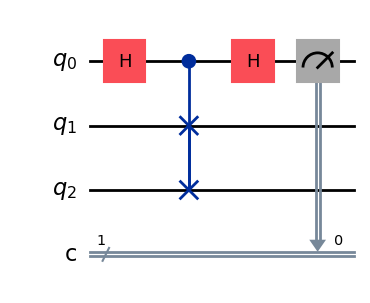

In [2]:
swap_circ = QuantumCircuit(3, 1)

swap_circ.h(0)
swap_circ.cswap(0, 1, 2)
swap_circ.h(0)
swap_circ.measure(0, 0)
swap_circ.draw('mpl')

The control qubit is initially placed in the state $|0\rangle$. Let us assume that qubit 1 is prepared in the state $|\psi\rangle$ and that qubit 2 is prepared in the state $|\phi\rangle$, as shown in the circuit diagram above. Thus the initial state of the circuit is $|\Psi\rangle = |0\psi \phi\rangle$. After the Hadamard on the control qubit this state becomes $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)|\psi \phi\rangle$. Then after the controlled-swap gate the state becomes $\frac{1}{\sqrt{2}}(|0 \psi \phi\rangle) + |1\phi\psi\rangle)$. The second Hadamard gives us the final state of the quantum circuit:
$\begin{equation}
    \frac{1}{2}(|0 \psi \phi\rangle+|1 \psi \phi\rangle+|0 \phi \psi\rangle-|1 \phi \psi\rangle)
\end{equation}$

We can see that when measuring the control qubit, the outcomes of the measurement are as follows:
$\begin{align}
    \textrm{Prob}(0) &= \frac{1}{4}(\langle \psi \phi| +  \langle\phi\psi|)(|\psi \phi\rangle + |\phi\psi\rangle) = \frac{1}{2} + \frac{1}{2}|\langle \psi | \phi \rangle|^2\\
    \textrm{Prob}(1) &= \frac{1}{4}(\langle \psi \phi| - \langle\phi\psi|)(|\psi \phi\rangle - |\phi\psi\rangle) = \frac{1}{2} - \frac{1}{2}|\langle \psi | \phi \rangle|^2
\end{align}$
Thus we can see that the fidelity will be given by the following:
$\begin{equation}
    \textrm{Fidelity} = |\langle \psi | \phi \rangle|^2 = \textrm{Prob}(0) - \textrm{Prob}(1)
\end{equation}$

Thus we can run the swap test circuit many times to statistically estimate the probabilities of measuring 0 and 1, and use these to find the fidelity between the two states.

### Training a Lambeq Model

In the Lambeq quantum pipeline, sentences are first turned into DisCoCat diagrams using a parser called BobCat. These sentences are then converted into **paramaterised quantum circuits** (PQCs). This involves mapping the DisCoCat diagrams to an *ansatz* quantum circuit. So far, I have chosen the Instantaneous Quantum Polynomial (IQP) ansatz, as this is the ansatz used in the [lambeq documentation and tutorials](https://docs.quantinuum.com/lambeq/). An example ansatz for the sentence **"I love UCl"** is shown below.

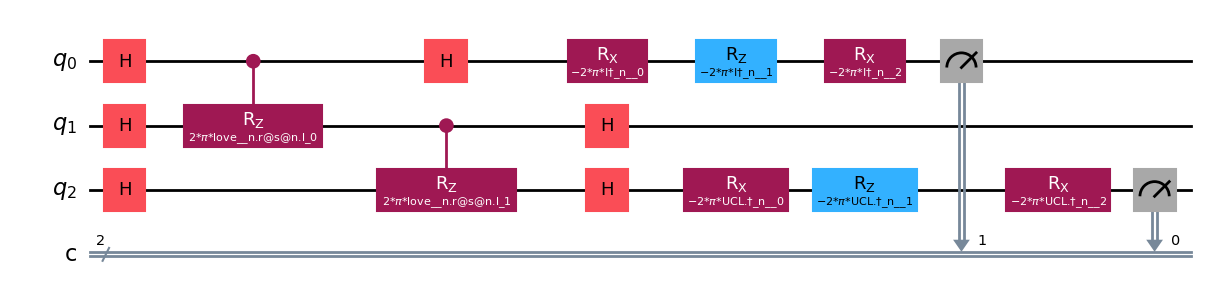

In [3]:
sentence = "I love UCL."
# Convert to DisCoCat diagram
parser = BobcatParser()
discocat_diagram = parser.sentence2diagram(sentence)
# Convert to PQC
remove_cups = RemoveCupsRewriter()
discocat_cupless = remove_cups(discocat_diagram)
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1, n_single_qubit_params=3)
PQC = ansatz(discocat_cupless)
# Draw
tk_to_qiskit(PQC.to_tk()).draw('mpl')

Quantum machine learning is used to optimize the parameters for the gates of each word in the vocabulary of the machine learning model. The untrained model is given a list of training sentences along with labels, which are essentially the desired outcomes of the measurement of the sentence qubit (which in the diagram above is qubit $q_1$). Lambeq uses the SPSA algorithm to optimize the parameters of the gates, with a variety of loss functions being available. Up to this point I have been working with data from a binary classification task, and so the loss function I used to train my model was the binary cross-entropy loss.

Once the training data has been fed into the model, it is simply a case of waiting for the training to finish. I made a [training notebook](../testing/training_new_model.ipynb) which outlines how to use lambeq for model training, and visualizes each step in greater detail.

Once the model has been trained, it can be tested, which is also shown in [a notebook](../testing/testing_model.ipynb). The accuracy of the model can be determined by measuring the sentence qubit at the output of each circuit, and comparing this to the desired output.

### Extracting Quantum Circuits and Composing Them for Fidelity Measurement

By default, parsing a sentence to a trained lambeq model will give the output of the measurement of the sentence qubit. In order to find the fidelity between two sentences, however, I needed to be able to extract the *exact state* of sentence qubits. This meant I needed a way of extracting the quantum circuits from the model. Thankfully, this was possible through the `_fast_subs` method of the model class. This is a private method, however accessing it publicly means I don't have to write my own extraction code from scratch, which makes life much easier.

The example below shows the optimized quantum circuit for the sentence **"woman prepares tasty dinner"**. This example uses function imported from [the module I wrote](../src/state_fidelity.py).

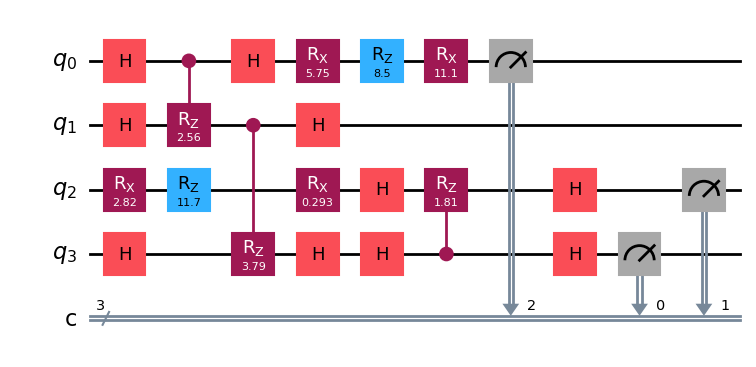

In [4]:
from src import state_fidelity

sentence = "woman prepares tasty dinner ."
model = state_fidelity.load_model("testing/model.lt")  # Load trained model
circuit = state_fidelity.sentences_to_circuits([sentence], model)[0]  # Obtain optimized quantum circuit
circuit.draw('mpl')

My module also includes a method to compose two sentence circuits together and add the swap test described above to measure the fidelity between the states of the two sentence qubits. Determining which qubits were the sentence qubits was simple: since all other qubits are measured, I simply found the two qubits which did not have a measurement gate applied to them.

This touches on an important point: **post-selection**. Due to the nature of the IQP ansatz, and the possibility of noise, there is a high chance that the other qubits in the circuit will enter undesired states. In order to test that this is not the case, all other qubits are measured, and should give a measurement outcome of zero. Thus whenever the circuit is run, I must check that all other qubits have given a measurement outcome of zero; otherwise, something has gone wrong, and I must discard the measurements from that run. As a result, when measuring fidelity I run each circuit $2^{16}$ times in order for the number of successful runs to be of the order of $10^3$.

The example below shows the full composed circuit for measuring the fidelity between the sentences **"woman cooks tasty sauce"** and **"skillful person runs software"**, and returns the fidelity between the two sentences as calculated by experimenting on IBM's noisy [Aer Simulator](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html).

In [7]:
sentence1 = "woman cooks tasty sauce ."
sentence2 = "skillful person runs software ."
fidelity, successful_runs = state_fidelity.fidelity_test(sentence1, sentence2, model, draw=True)
print(f"The fidelity is {fidelity}.\nThere were {successful_runs} successful runs.")

The fidelity is 0.01778907242693778.
There were 3148 successful runs.


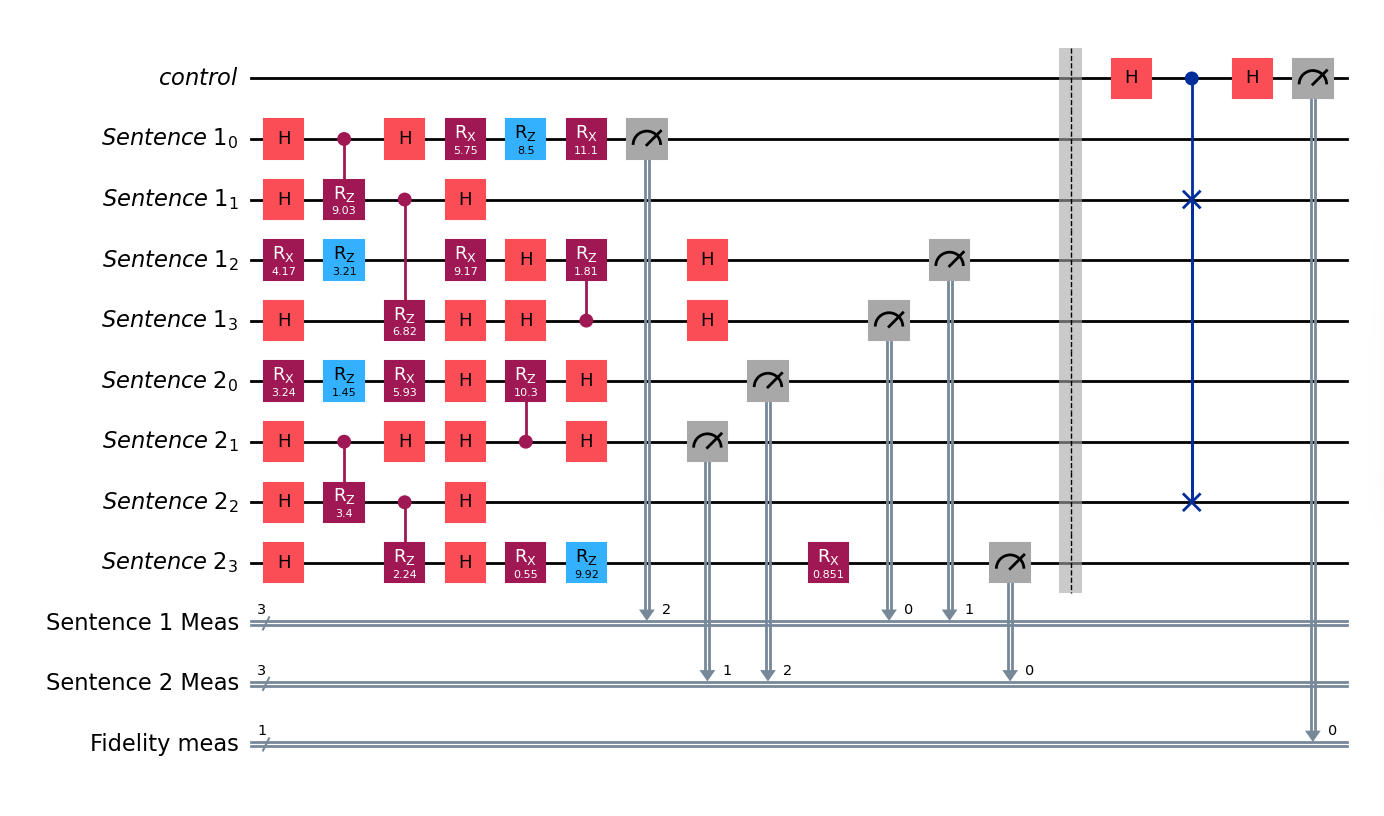

### Evaluation of Fidelity Measurements

During the previous phases of the project, I was simply "guessing" at whether the fidelity measurements were working - feeding my functions two sentences that were similar and seeing if they had a higher fidelity than two sentences that were different. However, my notions of 'similar' and 'different' are extremely subjective; I needed a quantitative way of evaluating the fidelity measurements.

The method I chose was to "skip ahead" slightly; I decided to take each sentence in the test dataset and rank each sentence in the training dataset in order of decrease similarity to the test sentence. The idea was to compare this ranking to a similar ranking made by a pre-trained and pre-proven BERT model to evaluate the performance of my quantum fidelity measurements.

Making the BERT rankings is trivial, since there are many pre-trained models available freely online. The method used to find the similarity between two sentences with my chosen BERT model is outlined in [a separate notebook](../testing/BERT_model_similarities.ipynb). I incorporated this code into a [separate module](../src/fidelity_accuracy_evaluator.py), which contains functions for retrieving the similarity rankings generated by both the BERT model and my lambeq model.

In the example below I parse the test sentence **""** and return the top-5 most similar training sentences as decided by both the BERT model and my Lambeq model.

In [8]:
from sentence_transformers import SentenceTransformer
from src import fidelity_accuracy_evaluator as fae

sentence = "skillful man prepares dinner ."
train_data = fae.ingest("testing/data/training_data.txt")
# Get BERT model rankings
bert_model = SentenceTransformer("all-MiniLM-L6-v2")  # Public pre-trained BERT model
bert_rankings = fae.get_bert_rankings(sentence, train_data.keys(), bert_model)
# Get lambeq model rankings
lambeq_model = state_fidelity.load_model("testing/model.lt")
lambeq_rankings = fae.get_lambeq_rankings(sentence, train_data.keys(), lambeq_model)
# Print top 5 BERT sentences
print("===BERT===")
for i in range(5):
    print(f"{i+1}:{list(bert_rankings.keys())[i+1]}")
# Print top 5 lambeq sentences
print("\n===LAMBEQ===")
for i in range(5):
    print(f"{i+1}:{list(lambeq_rankings.keys())[i+1]}")

===BERT===
1:skillful man cooks dinner .
2:man prepares meal .
3:skillful man cooks meal .
4:man cooks dinner .
5:skillful man bakes dinner .

===LAMBEQ===
1:skillful man bakes dinner .
2:skillful man bakes meal .
3:man bakes tasty dinner .
4:skillful person prepares meal .
5:person bakes dinner .


The example above shows that in this case, both the BERT and the LAMBEQ models have reasonable rankings, with all sentences seeming 'intuitively' similar.

I quantifiably compare the two using the [**Normalized Discounted Cumulative Gain**](https://towardsdatascience.com/demystifying-ndcg-bee3be58cfe0) (NDCG) metric,. This involves having an 'ideal' ranking, with every position having a score. Currently, I use the BERT ranking as the 'ideal' ranking (since I wish to compare my model directly with the BERT model). I then set the score of each sentence to be the **inverse of its position** (i.e if there are 10 sentences then the highest-ranked sentence has a score of 10, the next-highest has a score of 9 etc.). The data consists of sentences in two categories: food and IT. I zero the scores of any sentences which lie in a different category to the test sentence. I also multiply the top 5 scores by 2, to give more weight to the top 5 rankings.

In [my module](../src/fidelity_accuracy_evaluator.py) I obtain rankings and an NDCG for each test sentence. I then find the average NDCG value and use this as the quantitative metric of the performance of my quantum fidelity measurement circuit. 

In the example below, I run through one test sentence, **"woman bakes meal"**, and return the calculated NDCG value.

In [9]:
import src.fidelity_accuracy_evaluator as fae
sentence_data = {"woman bakes meal .": "1"}  # sentence:label where label represents category
ndcg = fae.ndcg_eval(sentence_data, train_data)
print(f"Calculated NDCG value is {ndcg}")

Calculated NDCG value is 0.8400160485480936


## Current Challenges
My main challenge regards the **evaluation of the fidelity measurements**. The NDCG calculation described above is a good first step, but requires some fine-tuning. The biggest issue is that the method of setting the scores for the rankings is incredibly arbitrary - I do not know if the method matters particularly, but I need to verify this. If it does matter, I need to find a way to choose a good way of scoring the rankings. I hope that my supervisor can be of help in this matter. 

Furthermore, obtaining the lambeq rankings is currently quite a slow process, which means running through every test sentence to obtain an average NDCG value takes around half an hour. As I have several experiments planned which utilize this measurement (see below), this is too long. I need to find a way to optimize my code so that it runs faster, allowing for much easier experimentation.

## Roadmap For The Future

Once I have addressed the issues above, I have several brief experiments in mind relating specifically to the fidelity measurement. I wish to see how different factors affect the accuracy of the fidelity measurements. I wish to conduct the following experiments:
- Investigating the fidelity impact of changing a sentence in different ways (e.g whether changing pronouns has a bigger impact than changing the verb used).
- Investigating whether the fidelity between two sentences is dependent on the ansatz used.
- Investigating the affect of the training hyperparameters on the fidelity between two sentences.

Beyond this, I have the following stretch goals in mind:
- Extend my fidelity measurement circuit into a full QKNN recommender system, similar to the one proposed [in this paper]( https://doi.org/10.1002/qute.202400122).
- Moving away from the lambeq docs datasets and creating my own, with more of a focus on real-world applications.
- Switch from simple binary classification to **multi-class** classification, and evaluate the impact on accuracy this has by repeating all the investigations above for the multi-class case.
- Increase the vocabulary of the models and evaluate the impact on accuracy.
